#  Project group 30 
## Image colorization by combining semantic segmentation and autoencoding 

Install dependencies

In [1]:
import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torch import nn
from torch import optim
import torchvision.transforms
from torchvision.transforms import Compose

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors

from PIL import Image, ImageOps 

Path 

In [2]:
train_path = "\Train"

val_path = "\Validation"

test_path = "\Test"

Dataloader

In [3]:
import torch.utils.data as data
import glob
import os

class DataLoaderSegmentation(data.Dataset):
    def __init__(self, folder_path, transform):
        super(DataLoaderSegmentation, self).__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            mask_path = self.mask_files[index]
            
            data = Image.open(img_path) # PIL images
            data = ImageOps.grayscale(data) 
        
            label = Image.open(mask_path) 
            
            # Perform transforms, if any.
            if self.transform is not None:
                data = self.transform(data)
                label = self.transform(label)
            
            data = np.array(data)
            np.moveaxis(data, 0, -1).shape
            
            label = np.array(label)
            np.moveaxis(label, 0, -1).shape

            # GÖR OM TILL GREY SCALE
            
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

Visualize test image

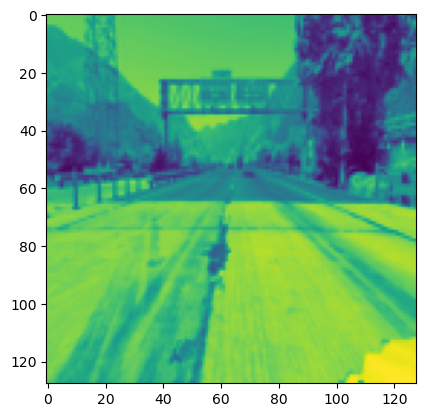

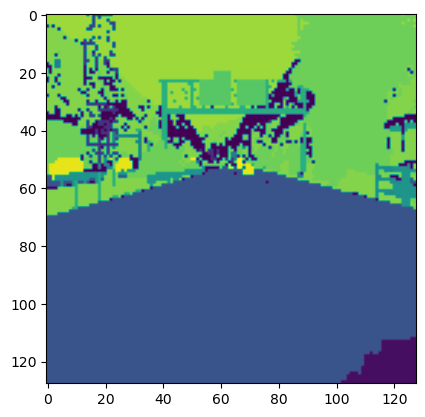

In [4]:
from torchvision.transforms import RandomGrayscale, ColorJitter, RandomHorizontalFlip, Resize, Normalize
example_transform = Compose([Resize((128,128), antialias=True)])
example_dataset = DataLoaderSegmentation(train_path,example_transform)

img, label = example_dataset[30]

plt.figure(0)
plt.imshow(img/torch.max(img))
plt.figure(1)
plt.imshow(label)



Convert from RGB to LAB

In [5]:
#!pip install kornia
from matplotlib.colors import LinearSegmentedColormap
import kornia

# L A B
# L - Lightness
# A - Red & Green
# B - Blue & Yellow

img_norm = img/255
img_lab = kornia.color.rgb_to_lab(img_norm.permute(2, 0, 1))

L = (img_lab.permute(1, 2, 0))[:,:,0]
A = (img_lab.permute(1, 2, 0))[:,:,1]
B = (img_lab.permute(1, 2, 0))[:,:,2]

Lfill = 50*torch.ones(L.shape)
Zfill = torch.zeros(L.shape)

Avis = kornia.color.lab_to_rgb(torch.stack((Lfill, A, Zfill),0)).permute(1, 2, 0)
Bvis = kornia.color.lab_to_rgb(torch.stack((Lfill, Zfill, B),0)).permute(1, 2, 0)

full_vis = kornia.color.lab_to_rgb(torch.stack((L, A, B),0)).permute(1, 2, 0)

plt.figure(0)
plt.imshow(L, "gray")
plt.figure(1)
plt.imshow(Avis)
plt.figure(2)
plt.imshow(Bvis)
plt.figure(3)
plt.imshow(full_vis)

RuntimeError: permute(sparse_coo): number of dimensions in the tensor input does not match the length of the desired ordering of dimensions i.e. input.dim() = 2 is not equal to len(dims) = 3

Perform transforms on the images maybe

Create dataloaders

In [9]:
#example_transform = Compose([Resize((128,128), antialias=True)])
#example_dataset = DataLoaderSegmentation(train_path,example_transform)

train_transforms = Compose([Resize((128,128), antialias=True)])

train_set = DataLoaderSegmentation(train_path, train_transforms)
val_set = DataLoaderSegmentation(val_path, train_transforms)

batch_size = 16
train_dataloader = DataLoader(train_set, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=batch_size, shuffle=True)

Build the model class

In [10]:
# Source
# https://medium.com/analytics-vidhya/unet-implementation-in-pytorch-idiot-developer-da40d955f201
class conv_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv1 = nn.Conv2d(in_c, out_c, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(out_c)
        self.conv2 = nn.Conv2d(out_c, out_c, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(out_c)
        self.relu = nn.ReLU()
            
    def forward(self, inputs):
        x = self.conv1(inputs)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        return x

    
class encoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.conv = conv_block(in_c, out_c)
        self.pool = nn.MaxPool2d((2, 2))
    def forward(self, inputs):
        x = self.conv(inputs)
        p = self.pool(x)
        return x, p

class decoder_block(nn.Module):
    def __init__(self, in_c, out_c):
        super().__init__()
        self.up = nn.ConvTranspose2d(in_c, out_c, kernel_size=2, stride=2, padding=0)
        self.conv = conv_block(out_c+out_c, out_c)
    def forward(self, inputs, skip):
        x = self.up(inputs) 
        x = torch.cat([x, skip], axis=1)
        x = self.conv(x)
        return x

    
class build_unet(nn.Module):
    def __init__(self):
        super().__init__()
        """ Encoder """
        self.e1 = encoder_block(1, 64)
        self.e2 = encoder_block(64, 128)
        self.e3 = encoder_block(128, 256)
        self.e4 = encoder_block(256, 512)
        """ Bottleneck """
        self.b = conv_block(512, 1024)
        """ Decoder """
        self.d1 = decoder_block(1024, 512)
        self.d2 = decoder_block(512, 256)
        self.d3 = decoder_block(256, 128)
        self.d4 = decoder_block(128, 64) 
        """ Classifier """
        self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)
    def forward(self, inputs):
        """ Encoder """
        inputs = inputs.permute(1,0,2,3)
        s1, p1 = self.e1(inputs)  
        s2, p2 = self.e2(p1)
        s3, p3 = self.e3(p2)
        s4, p4 = self.e4(p3)
        """ Bottleneck """
        b = self.b(p4)
        """ Decoder """
        d1 = self.d1(b, s4)
        d2 = self.d2(d1, s3)
        d3 = self.d3(d2, s2)
        d4 = self.d4(d3, s1)
        """ Classifier """
        outputs = self.outputs(d4)
        return outputs

Build the training loop

In [11]:
# custom colormap
cmap = colors.ListedColormap(['k','b','y','g','r','darkorange','forestgreen','lime','seagreen','royalblue','navy','indigo','teal','gold','tan','aqua','coral','olive','purple','maroon','turquoise','lightsalmon','pink','plum','khaki','lawngreen','peru','lightgray','wheat','sienna','fuchsia','thistle'])

def training_loop(model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every):
    print("Starting training")
    device = torch.device("cuda" if torch.cuda.is_available() 
                                  else "cpu")
    model.to(device)
    train_losses, train_accs, val_losses, val_accs = [], [], [], []

    for epoch in range(1, num_epochs+1):
        model, train_loss, train_acc = train_epoch(model,
                                                   optimizer,
                                                   loss_fn,
                                                   train_loader,
                                                   val_loader,
                                                   device,
                                                   print_every)
        # Validate fucks up
        val_loss, val_acc = validate(model, loss_fn, val_loader, device)
        print(f"Epoch {epoch}/{num_epochs}: "
              f"Train loss: {sum(train_loss)/len(train_loss):.3f}, "
              f"Train acc.: {sum(train_acc)/len(train_acc):.3f}, "
              f"Val. loss: {val_loss:.3f}, "
              f"Val. acc.: {val_acc:.3f}")
        train_losses.extend(train_loss)
        train_accs.extend(train_acc)
        val_losses.append(val_loss)
        val_accs.append(val_acc)

        # Save model to disk after each epoch
        torch.save(model.state_dict(), 'segmentation_model.pth')
        
    return model, train_losses, train_accs, val_losses, val_accs

def train_epoch(model, optimizer, loss_fn, train_loader, val_loader, device, print_every):
    # Train:
    model.train()
    train_loss_batches, train_acc_batches = [], []
    num_batches = len(train_loader)
    for batch_index, (x, y) in enumerate(train_loader, 1):    
        inputs, labels = x.to(device), y.to(device)
        inputs = inputs[None, :]
        
        optimizer.zero_grad()
        z = model.forward(inputs)
        z = torch.squeeze(z)
        #z = torch.round((z+1)*16) # 32 classes
        loss = loss_fn(z, labels.float())
        loss.backward()
        optimizer.step()
        train_loss_batches.append(loss.item())


        print("Thinking.... ", batch_index)
        # If you want to print your progress more often than every epoch you can
        # set `print_every` to the number of batches you want between every status update.
        # Note that the print out will trigger a full validation on the full val. set => slows down training
        if print_every is not None and batch_index % print_every == 0:
            val_loss, val_acc = validate(model, loss_fn, val_loader, device)
            model.train()
            print(f"\tBatch {batch_index}/{num_batches}: "
                  f"\tTrain loss: {sum(train_loss_batches[-print_every:])/print_every:.3f}, "
                  f"\tTrain acc.: {sum(train_acc_batches[-print_every:])/print_every:.3f}, "
                  f"\tVal. loss: {val_loss:.3f}, "
                  f"\tVal. acc.: {val_acc:.3f}")

    return model, train_loss_batches, train_acc_batches

def validate(model, loss_fn, val_loader, device):
    val_loss_cum = 0
    val_acc_cum = 0
    model.eval()
    with torch.no_grad():
        for batch_index, (x, y) in enumerate(val_loader, 1):
            inputs, labels = x.to(device), y.to(device)
            inputs = inputs[None, :]
            
            z_ = model.forward(inputs)
            z = torch.squeeze(z_)
            #z = torch.round((z+1)*16) # 32 classes
            
            batch_loss = loss_fn(z, labels.float()) #######################################
            val_loss_cum += batch_loss.item()      
            
            # Visual test
            if batch_index == 1:
                f, axarr = plt.subplots(1,3)
                axarr[0].imshow(inputs[0,0,:,:],'grey')
                # With static cmap
                axarr[1].imshow(z[0,:,:],cmap)
                axarr[2].imshow(labels.float()[0,:,:],cmap)

                # Without static cmap
                #axarr[1].imshow(z[0,:,:])
                #axarr[2].imshow(labels.float()[0,:,:])
                
                plt.show()
                # Save the model each time we plot (REMOVE LATER)
                torch.save(model.state_dict(), 'segmentation_model.pth')

    return val_loss_cum/len(val_loader), val_acc_cum/len(val_loader)


Text

reding model from disk
Starting training
Thinking....  1


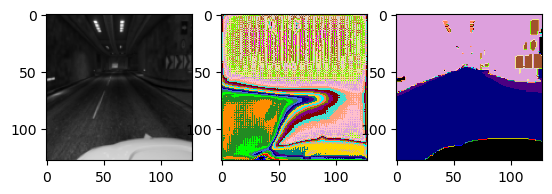

	Batch 1/125: 	Train loss: 6644.707, 	Train acc.: 0.000, 	Val. loss: 7314.621, 	Val. acc.: 0.000
Thinking....  2


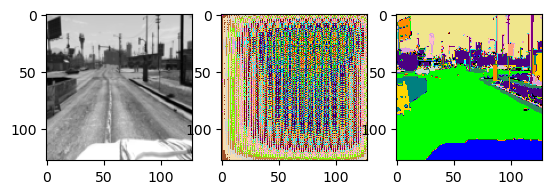

	Batch 2/125: 	Train loss: 6921.725, 	Train acc.: 0.000, 	Val. loss: 16818.082, 	Val. acc.: 0.000
Thinking....  3


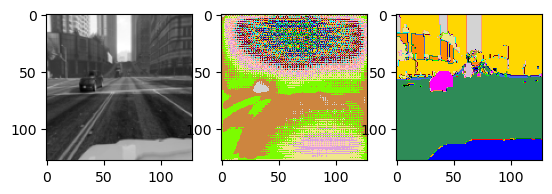

	Batch 3/125: 	Train loss: 7075.174, 	Train acc.: 0.000, 	Val. loss: 12748.656, 	Val. acc.: 0.000
Thinking....  4


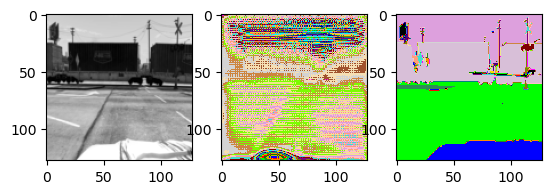

	Batch 4/125: 	Train loss: 7153.500, 	Train acc.: 0.000, 	Val. loss: 8339.706, 	Val. acc.: 0.000
Thinking....  5


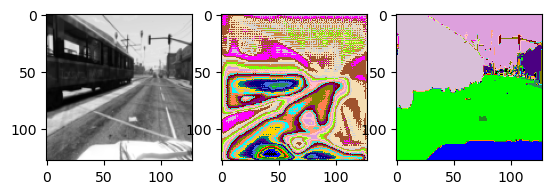

	Batch 5/125: 	Train loss: 6722.232, 	Train acc.: 0.000, 	Val. loss: 7447.796, 	Val. acc.: 0.000
Thinking....  6


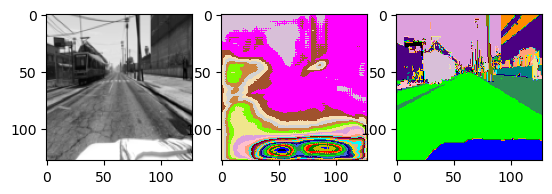

	Batch 6/125: 	Train loss: 7073.829, 	Train acc.: 0.000, 	Val. loss: 8165.774, 	Val. acc.: 0.000
Thinking....  7


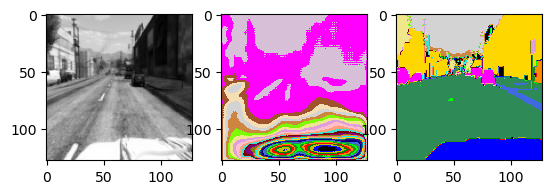

KeyboardInterrupt: 

In [12]:
train_from_disk = True

if train_from_disk:  
    # Read model from disk
    print("reding model from disk")
    pretrained = torch.load('segmentation_model.pth', map_location=lambda storage, loc: storage)
    Segmentaion_model = build_unet()
    Segmentaion_model.load_state_dict(torch.load('segmentation_model.pth'))
else:
    # Create new model
    print("creating new model")
    Segmentaion_model = build_unet()



optimizer = optim.Adam(Segmentaion_model.parameters(), lr =0.001)
#loss_fn = nn.MSELoss() # kass som faen
loss_fn = nn.CrossEntropyLoss() # mindre kass
train_loader = train_dataloader 
val_loader = val_dataloader
num_epochs = 1
print_every = 1

Segmentaion_model, Segmentaion_train_losses, Segmentaion_train_accs, Segmentaion_val_losses, Segmentaion_val_accs= training_loop(Segmentaion_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)



Text

Dataloader autoencoder

In [ ]:
class DataLoaderAutoEncoder(data.Dataset):
    def __init__(self, folder_path, transform):
        super().__init__()
        
        #print(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.transform = transform
        
        self.img_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Images\*.png")
        self.mask_files = glob.glob(os.getcwd() + "\Dataset" + folder_path + "\Labels\*.png")

    def __getitem__(self, index):
            img_path = self.img_files[index]
            
            data = Image.open(img_path) 
            data = ImageOps.grayscale(data)
            img_rgb = Image.open(img_path)
        
            # Perform transforms, if any.
            if self.transform is not None:
                data = self.transform(data)
                label = self.transform(img_rgb)
            
            data = np.array(data)
            np.moveaxis(data, 0, -1).shape
            
            label = np.array(label)
            np.moveaxis(label, 0, -1).shape

            img_norm = label/255
            img_lab = kornia.color.rgb_to_lab(img_norm.permute(2, 0, 1))
            label = img_lab[:, :, 1:]
     
        
            return torch.from_numpy(data).float(), torch.from_numpy(label).float()

    def __len__(self):
        return len(self.img_files)

In [ ]:
train_transforms = Compose([Resize((128,128), antialias=True)])

train_set_autoencoder = DataLoaderAutoEncoder(train_path, train_transforms)
val_set_autoencoder = DataLoaderAutoEncoder(val_path, train_transforms)

batch_size = 16
train_dataloader_autoencoder = DataLoader(train_set_autoencoder, batch_size=batch_size, shuffle=True)
val_dataloader_autoencoder = DataLoader(val_set_autoencoder, batch_size=batch_size, shuffle=True)

In [ ]:
autoencoder_model = build_unet()
loss_fn = nn.MSELoss()
optimizer = optim.Adam(autoencoder_model.parameters(), lr =0.001)
train_loader = train_dataloader_autoencoder
val_loader = val_dataloader_autoencoder
num_epochs = 1
print_every = 1

autoencoder_model, autoencoder_train_losses, autoencoder_train_accs, autoencoder_val_losses, autoencoder_val_accs= training_loop(autoencoder_model, optimizer, loss_fn, train_loader, val_loader, num_epochs, print_every)